# 10.31 과제 
**B3유해정**\
목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를  생성하여 회귀분석을 실시하여 결과를 해석하고, predict method를 이용하여 예측값을 구하라.\
(BMI 계산 시, WEIGHT 단위는 pound(1lb=0.45kg), HEIGHT 단위는 inch(1inch=2.54cm)이므로 변환하여 사용할 것)\
데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

(1) VIF와 선형회귀모형을 직접 확인하고 하나씩 변수를 제거하는 방법과\
(2)후진제거법 함수(RFE)를 사용하는 방법을 나누어 실행해보았습니다.

In [1]:
#라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#회귀분석
from statsmodels.formula.api import ols
#qq plot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
#선형 모델 formula
import statsmodels.formula.api as smf
#평가함수
from statsmodels.tools.eval_measures import rmse

In [2]:
import matplotlib.font_manager as fm
path =  '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
fontprop = fm.FontProperties(fname=path, size=18).get_name()

matplotlib.rc('font', family=fontprop)트
matplotlib.rc("axes",unicode_minus=False)

import warnings
warnings.filterwarnings("ignore")

In [3]:
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#학습용/평가용 데이터 분리
from sklearn.model_selection import train_test_split
#선형회귀 모형
from sklearn.linear_model import LinearRegression
#변수선택법(후진제거법)
from sklearn.feature_selection import RFE
#Scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
#평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
#데이터 불러오기
df_raw = pd.read_csv("221026_Big Data 분석_실습화일/1 Big Data 분석 기초/체질검사.csv")
df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST  
0    45.0     29.0   21.4  
1    29.0     30.0   18.8  
2    30.8     25.7   18.8  
3    31.7     27.3   16.9  
4    34.7     29.1   18.4

- BMI = BMI (kg/m^2)
- pound(1lb= 0.45kg), HEIGHT 단위는 inch(1inch= 2.54cm)

In [5]:
#weight와 height를 각각 kg, cm로 변경하고 BMI지수 계산
df_raw['BMI'] = df_raw['WEIGHT']*0.45/(df_raw['HEIGHT']*2.54/100)**2
df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST        BMI  
0    45.0     29.0   21.4  48.523870  
1    29.0     30.0   18.8  23.082595  
2    30.8     25.7   18.8  26.422478  
3    31.7     27.3   16.9  23.838617  
4    34.7     29.1   18.4  37.293165

In [6]:
#null값 확인
df_raw.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
BMI        0
dtype: int64

- 결측치는 없음

In [7]:
#기술통계량 확인
df_raw.describe()

FAT         AGE      WEIGHT      HEIGHT        NECK       CHEST  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    19.150794   44.884921  178.924405   70.148810   37.992063  100.824206   
std      8.368740   12.602040   29.389160    3.662856    2.430913    8.430476   
min      0.000000   22.000000  118.500000   29.500000   31.100000   79.300000   
25%     12.475000   35.750000  159.000000   68.250000   36.400000   94.350000   
50%     19.200000   43.000000  176.500000   70.000000   38.000000   99.650000   
75%     25.300000   54.000000  197.000000   72.250000   39.425000  105.375000   
max     47.500000   81.000000  363.150000   77.750000   51.200000  136.200000   

          ABDOMEN         HIP       THIGH        KNEE       ANKLE      BICEPS  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    92.555952   99.904762   59.405952   38.590476   23.102381   32.273413   
std     10.783077    7.164058    5.249952    2.411805    1.694893    3.021274   
min     69.400000   85.000000   47.200000   33.000000   19.100000   24.800000   
25%     84.575000   95.500000   56.000000   36.975000   22.000000   30.200000   
50%     90.950000   99.300000   59.000000   38.500000   22.800000   32.050000   
75%     99.325000  103.525000   62.350000   39.925000   24.000000   34.325000   
max    148.100000  147.700000   87.300000   49.100000   33.900000   45.000000   

          FOREARM       WRIST         BMI  
count  252.000000  252.000000  252.000000  
mean    28.663889   18.229762   25.736762  
std      2.020691    0.933585    9.482758  
min     21.000000   15.800000   17.874982  
25%     27.300000   17.600000   22.853241  
50%     28.700000   18.300000   24.895566  
75%     30.000000   18.800000   27.118085  
max     34.900000   21.400000  164.306562

- WEIGHT와 BMI에서 수상한 최대값 발견

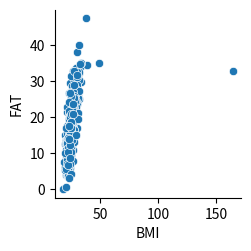

In [9]:
#산점도로 확인
sns.pairplot(df_raw, y_vars="FAT", x_vars=["BMI"])

- 산점도를 보니 BMI가 높은 이상치를 발견했습니다.

In [10]:
#이상데이터 조회
df_raw[df_raw["BMI"]>150]

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  \
78  32.9   44   205.0    29.5  36.6  106.0    104.3  115.5   70.6  42.5   

    ANKLE  BICEPS  FOREARM  WRIST         BMI  
78   23.7    33.6     28.7   17.4  164.306562

 -> 키가 29.5인치이고 몸무게가 205파운드인 이상치를 발견했습니다.

In [11]:
#비슷한 데이터를 찾을 만한 적합한 특성이 없다고 판단하여 행 드랍
df_raw.drop(index = 78, inplace = True)

In [13]:
df_raw.iloc[76:80]

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN   HIP  THIGH  KNEE  ANKLE  \
76  18.4   64  190.25   72.75  39.3  103.1     97.8  99.6   58.9  39.0   23.0   
77  14.1   48  176.00   73.00  36.7   96.7     86.5  98.3   60.4  39.9   24.4   
79   3.7   27  159.25   71.50  35.7   89.6     79.7  96.5   55.0  36.7   22.5   
80  18.5   61  148.25   67.50  36.0   91.6     81.8  94.8   54.5  37.0   21.4   

    BICEPS  FOREARM  WRIST        BMI  
76    34.3     29.6   19.0  25.072853  
77    28.8     29.6   18.7  23.036263  
79    29.9     28.2   17.7  21.727634  
80    29.3     27.0   18.3  22.695107

- 78번째 행이 잘 drop된 것을 확인

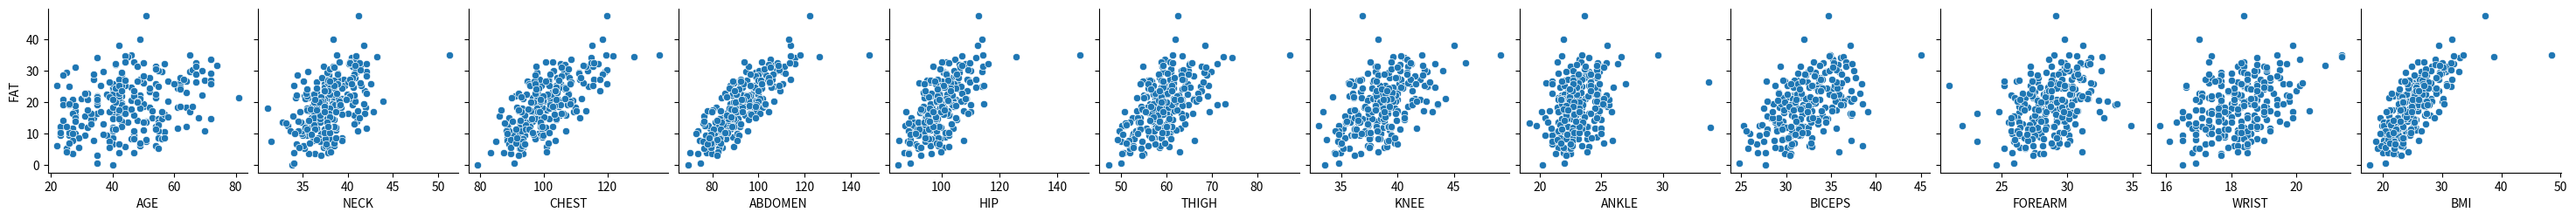

In [15]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["AGE","NECK","CHEST","ABDOMEN","HIP","THIGH","KNEE","ANKLE","BICEPS","FOREARM","WRIST","BMI"])

- age를 제외하고 대부분 목표변수와 양의 선형성을 띄는 것처럼 보임

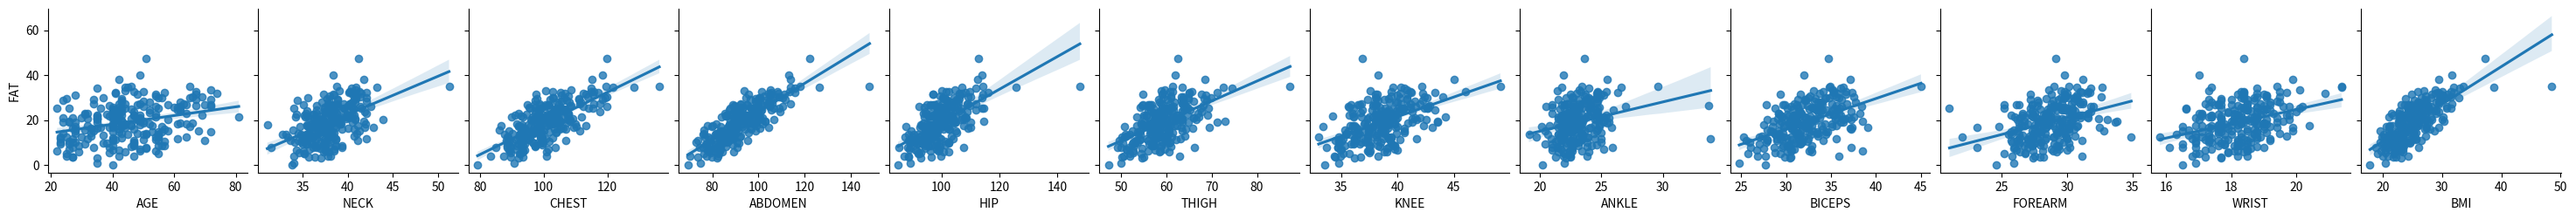

In [17]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["AGE","NECK","CHEST","ABDOMEN","HIP","THIGH","KNEE","ANKLE","BICEPS","FOREARM","WRIST","BMI"],kind="reg")

목표변수와 다수 설명변수 간의 선형관계 확인 -> 이상치 처리 검토 및 적절한 설명변수 선택 필요

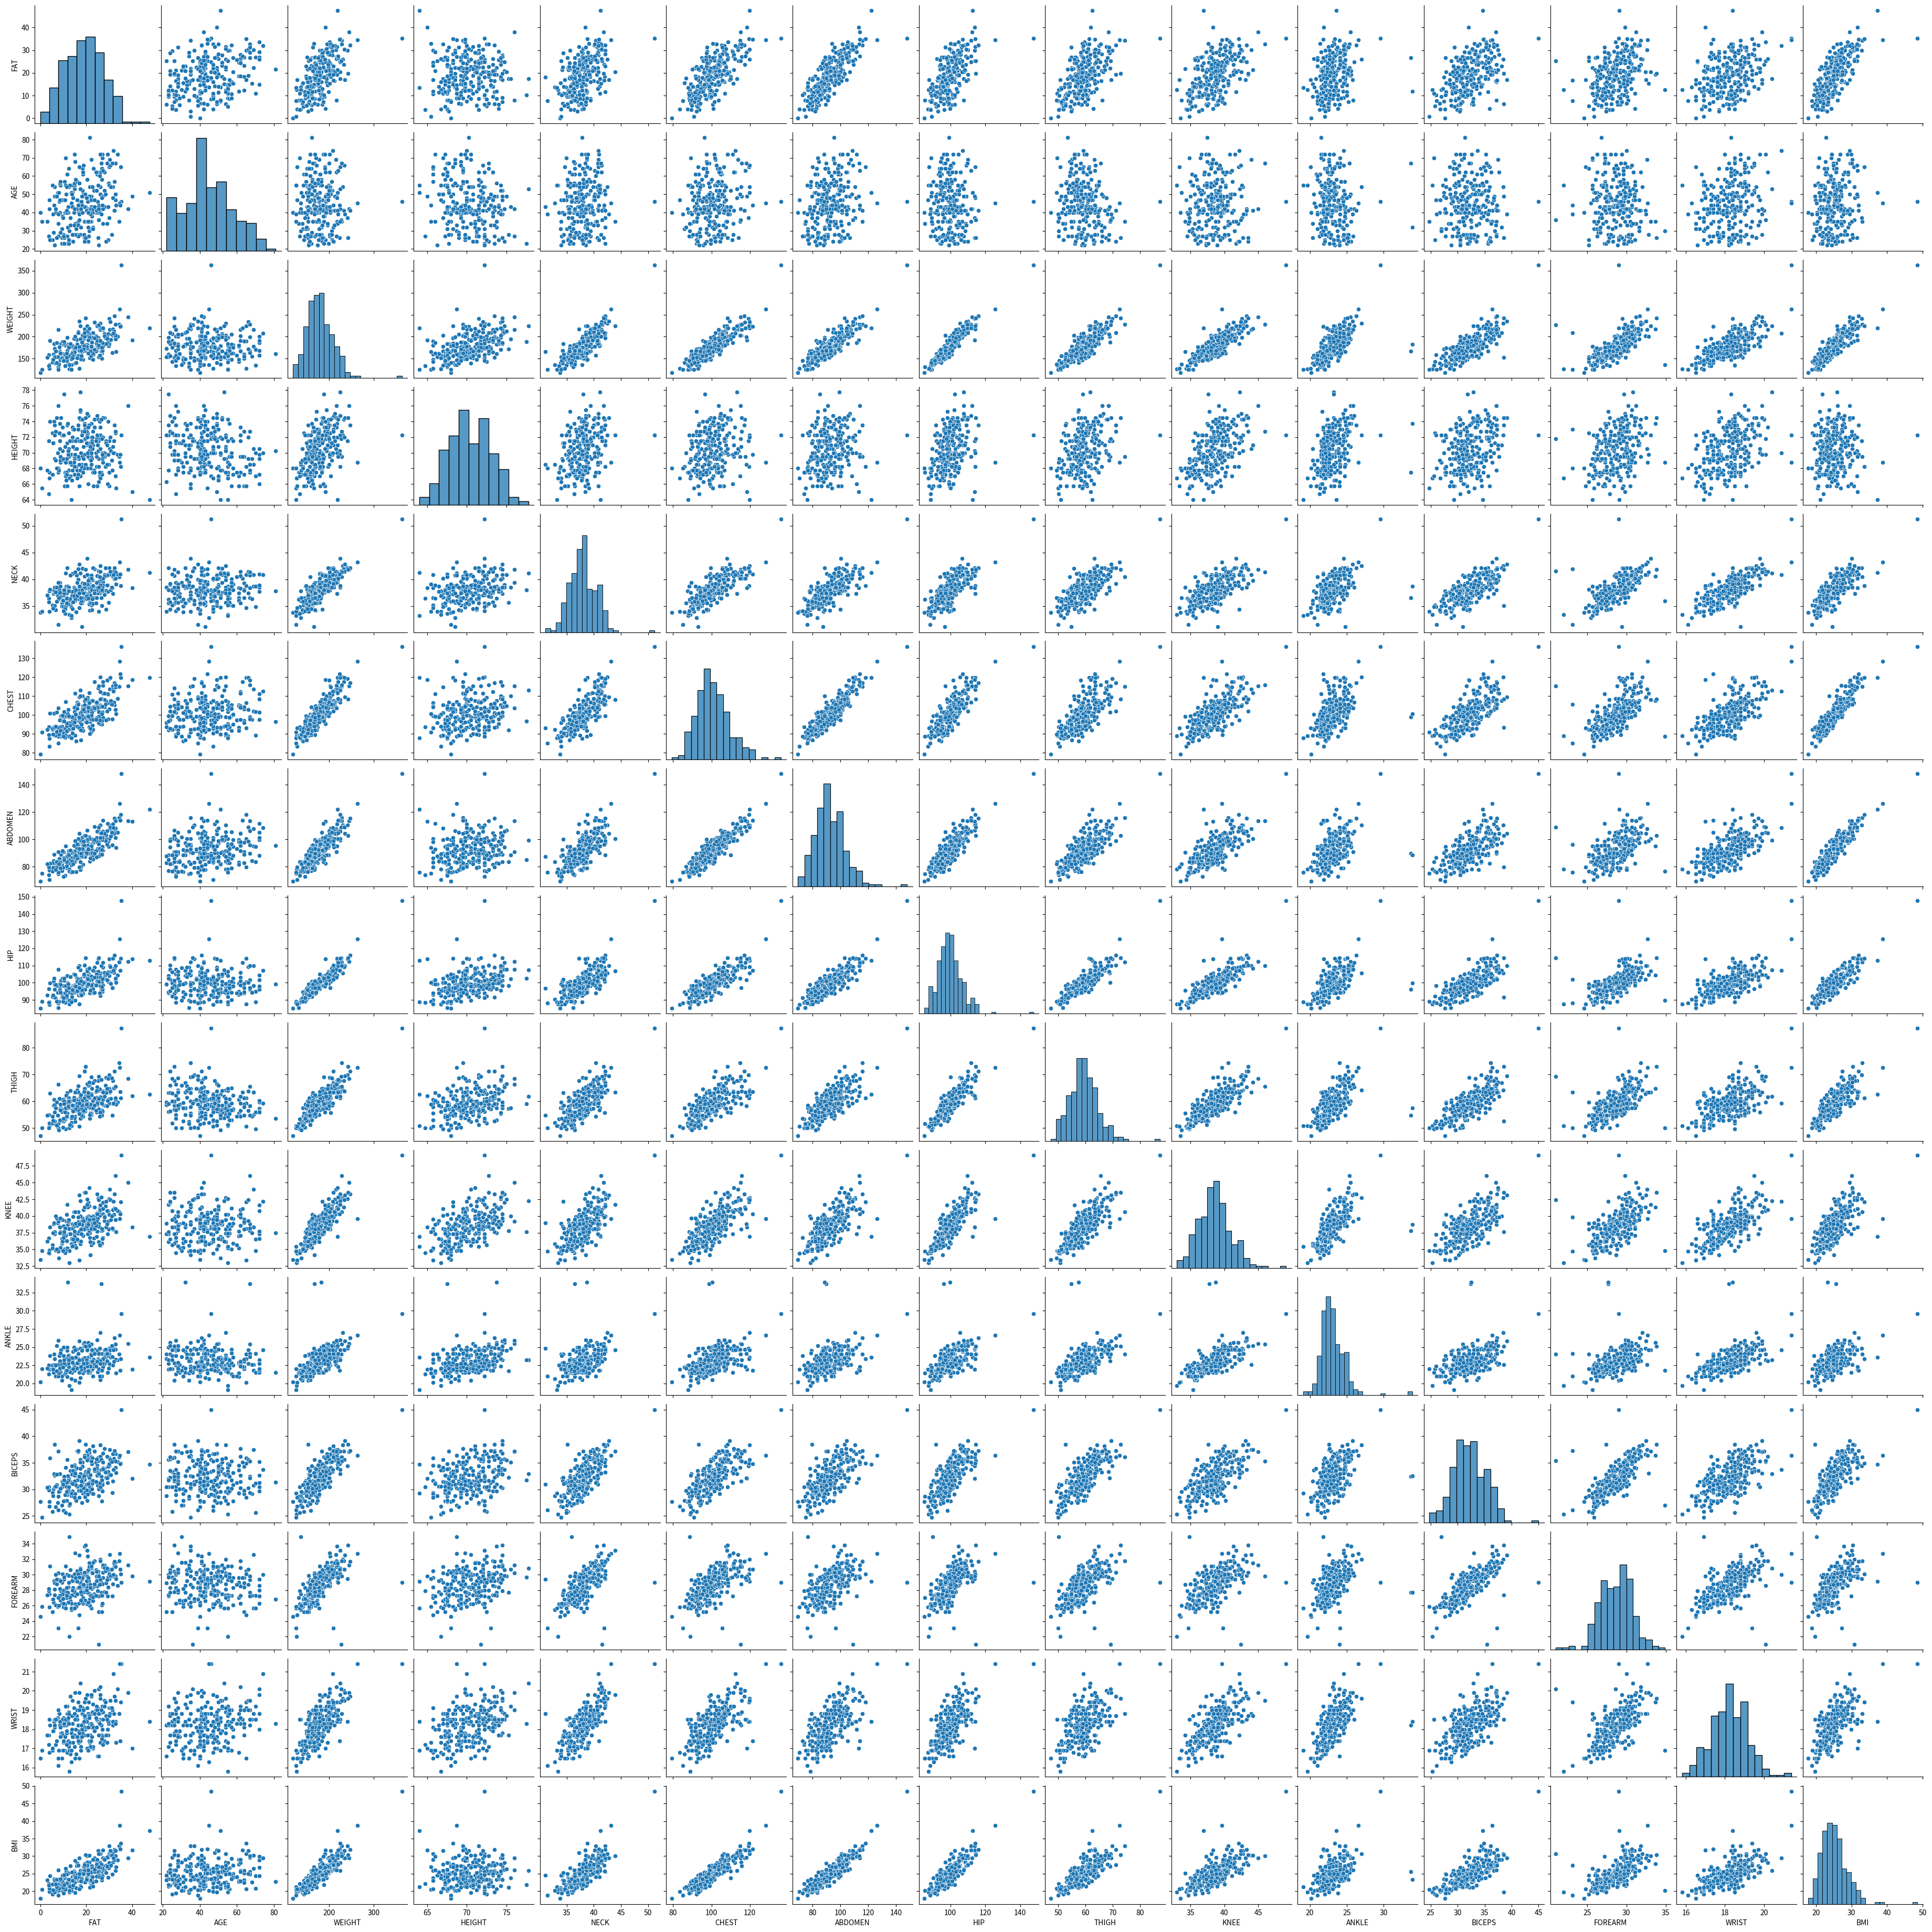

In [19]:
#산점도 행렬
sns.pairplot(df_raw)

- 특히 BMI 변수에서 다른 몇몇 설명변수들과 선형관계가 두드러짐

In [20]:
#상관관계 분석
df_raw.corr().round(3)

FAT    AGE  WEIGHT  HEIGHT   NECK  CHEST  ABDOMEN    HIP  THIGH  \
FAT      1.000  0.294   0.611  -0.023  0.497  0.703    0.813  0.620  0.554   
AGE      0.294  1.000  -0.013  -0.245  0.113  0.177    0.231 -0.050 -0.201   
WEIGHT   0.611 -0.013   1.000   0.489  0.835  0.894    0.888  0.944  0.870   
HEIGHT  -0.023 -0.245   0.489   1.000  0.321  0.228    0.192  0.378  0.344   
NECK     0.497  0.113   0.835   0.321  1.000  0.787    0.759  0.748  0.708   
CHEST    0.703  0.177   0.894   0.228  0.787  1.000    0.916  0.833  0.732   
ABDOMEN  0.813  0.231   0.888   0.192  0.759  0.916    1.000  0.875  0.766   
HIP      0.620 -0.050   0.944   0.378  0.748  0.833    0.875  1.000  0.894   
THIGH    0.554 -0.201   0.870   0.344  0.708  0.732    0.766  0.894  1.000   
KNEE     0.503  0.018   0.853   0.505  0.680  0.720    0.736  0.821  0.797   
ANKLE    0.265 -0.105   0.614   0.394  0.479  0.483    0.453  0.561  0.542   
BICEPS   0.493 -0.041   0.800   0.319  0.733  0.728    0.685  0.743  0.765   
FOREARM  0.363 -0.085   0.631   0.322  0.624  0.581    0.504  0.550  0.572   
WRIST    0.355  0.214   0.735   0.397  0.744  0.664    0.626  0.645  0.572   
BMI      0.725  0.115   0.888   0.039  0.785  0.910    0.922  0.885  0.814   

          KNEE  ANKLE  BICEPS  FOREARM  WRIST    BMI  
FAT      0.503  0.265   0.493    0.363  0.355  0.725  
AGE      0.018 -0.105  -0.041   -0.085  0.214  0.115  
WEIGHT   0.853  0.614   0.800    0.631  0.735  0.888  
HEIGHT   0.505  0.394   0.319    0.322  0.397  0.039  
NECK     0.680  0.479   0.733    0.624  0.744  0.785  
CHEST    0.720  0.483   0.728    0.581  0.664  0.910  
ABDOMEN  0.736  0.453   0.685    0.504  0.626  0.922  
HIP      0.821  0.561   0.743    0.550  0.645  0.885  
THIGH    0.797  0.542   0.765    0.572  0.572  0.814  
KNEE     1.000  0.613   0.680    0.559  0.675  0.709  
ANKLE    0.613  1.000   0.485    0.419  0.568  0.497  
BICEPS   0.680  0.485   1.000    0.678  0.635  0.747  
FOREARM  0.559  0.419   0.678    1.000  0.587  0.561  
WRIST    0.675  0.568   0.635    0.587  1.000  0.635  
BMI      0.709  0.497   0.747    0.561  0.635  1.000

- BMI가 체질량 지수를 나타내서 그런지 웬만한 둘레들과 높은 상관관계를 가지고 있는 듯하다.
- 또 데이터의 종류가 둘레길이만 있어 대부분 다중공선성이 있다.\
(어느 한 둘레는 두꺼우면서 다른 둘레는 얇기 어렵기 때문에)

In [21]:
#데이터는 (train(0.6) : test(0.4) )의 비율로 분할
df_train, df_test = train_test_split(df_raw, test_size = 0.4, random_state=1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (150, 15)
test data size : (101, 15)


In [23]:
#선형회귀분석 
reg_model = smf.ols(formula = "FAT ~ AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     28.28
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.29e-33
Time:                        19:40:12   Log-Likelihood:                -429.93
No. Observations:                 150   AIC:                             889.9
Df Residuals:                     135   BIC:                             935.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -190.6032     73.021     -2.610      0.0

**해석**
- Prob(Omnibus) : 0.229 > 0.05 이므로 정규성 만족
- Durbin-Watson : 2.205이므로 2에 가까워 독립성 만족
- No. Observations: 175 분석 자료수
- Df Residuals: 162 잔차자유도
- Df Model: 12 모델자유도
- prob p값이 2.12e-40으로 유의수준 0.05보다 작으므로 회귀모델로서 유의하다.
- 설명력 0.734 -> 주어진 설명변수들로 FAT의 변동의 73.4%를 설명할 수 있음
- 회귀계수 검정(t) -> 절편의 유의성(Intercept)는 검토하지 않음

## 1) VIF와 선형회귀모형을 직접 확인하고 하나씩 변수를 제거하는 방법

In [24]:
df_train_x = df_train.drop(["FAT"],axis=1)

#statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["Vaiable"] = df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

Vaiable       VIF
10    ANKLE      2.20
12  FOREARM      2.59
1       AGE      2.65
13    WRIST      3.42
4      NECK      4.58
11   BICEPS      4.71
9      KNEE      4.72
8     THIGH      7.86
5     CHEST     11.17
6   ABDOMEN     15.41
7       HIP     15.81
3    HEIGHT     53.67
14      BMI    246.51
2    WEIGHT    261.54
0     const  39824.86

In [25]:
#VIF값이 10이 넘어가는 변수 중 가장 큰 WEIGHT변수 삭제
df_train_x = df_train.drop(["WEIGHT"],axis=1)

#statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["Vaiable"] = df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

Vaiable      VIF
10    ANKLE     2.20
12  FOREARM     2.46
2       AGE     2.65
13    WRIST     3.55
1       FAT     3.71
11   BICEPS     4.51
9      KNEE     4.52
4      NECK     4.62
3    HEIGHT     5.51
8     THIGH     7.77
5     CHEST    11.07
7       HIP    16.31
6   ABDOMEN    20.92
14      BMI    39.10
0     const  1112.80

In [26]:
#선형회귀분석 
reg_model = smf.ols(formula = "FAT ~ AGE+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     28.36
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.87e-32
Time:                        19:43:59   Log-Likelihood:                -434.28
No. Observations:                 150   AIC:                             896.6
Df Residuals:                     136   BIC:                             938.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8643     12.463      1.112      0.2

In [30]:
#p값이 가장 큰 HEIGHT 삭제
reg_model = smf.ols(formula = "FAT ~ AGE+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     30.93
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.33e-33
Time:                        19:46:42   Log-Likelihood:                -434.30
No. Observations:                 150   AIC:                             894.6
Df Residuals:                     137   BIC:                             933.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6111     10.634      1.186      0.2

In [32]:
#p값이 그다음으로 큰 THIGH 삭제
reg_model = smf.ols(formula = "FAT ~ AGE+NECK+CHEST+ABDOMEN+HIP+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     33.98
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           5.70e-34
Time:                        19:47:16   Log-Likelihood:                -434.33
No. Observations:                 150   AIC:                             892.7
Df Residuals:                     138   BIC:                             928.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9012     10.521      1.226      0.2

In [33]:
#p값이 그다음으로 큰 KNEE 삭제
reg_model = smf.ols(formula = "FAT ~ AGE+NECK+CHEST+ABDOMEN+HIP+ANKLE+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     37.60
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           9.55e-35
Time:                        19:47:36   Log-Likelihood:                -434.39
No. Observations:                 150   AIC:                             890.8
Df Residuals:                     139   BIC:                             923.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1092     10.470      1.252      0.2

In [34]:
#p값이 그다음으로 큰 ANKLE 삭제
reg_model = smf.ols(formula = "FAT ~ AGE+NECK+CHEST+ABDOMEN+HIP+BICEPS+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     41.85
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.87e-35
Time:                        19:48:05   Log-Likelihood:                -434.69
No. Observations:                 150   AIC:                             889.4
Df Residuals:                     140   BIC:                             919.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.7441     10.418      1.319      0.1

In [35]:
#p값이 그다음으로 큰 BICEPS 삭제
reg_model = smf.ols(formula = "FAT ~ AGE+NECK+CHEST+ABDOMEN+HIP+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     47.08
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.76e-36
Time:                        19:48:36   Log-Likelihood:                -435.08
No. Observations:                 150   AIC:                             888.2
Df Residuals:                     141   BIC:                             915.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0142     10.372      1.255      0.2

In [37]:
#p값이 그다음으로 큰 AGE 삭제
reg_model = smf.ols(formula = "FAT ~NECK+CHEST+ABDOMEN+HIP+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     53.59
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           8.65e-37
Time:                        19:49:05   Log-Likelihood:                -435.69
No. Observations:                 150   AIC:                             887.4
Df Residuals:                     142   BIC:                             911.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4237      9.878      1.663      0.0

In [38]:
#p값이 그다음으로 큰 CHEST 삭제
reg_model = smf.ols(formula = "FAT ~NECK+ABDOMEN+HIP+FOREARM+WRIST+BMI", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     61.89
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.52e-37
Time:                        19:49:22   Log-Likelihood:                -436.62
No. Observations:                 150   AIC:                             887.2
Df Residuals:                     143   BIC:                             908.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4276      9.439      1.317      0.1

In [39]:
#p값이 그다음으로 큰 BMI 삭제
reg_model = smf.ols(formula = "FAT ~NECK+ABDOMEN+HIP+FOREARM+WRIST", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     73.48
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           6.79e-38
Time:                        19:49:53   Log-Likelihood:                -437.57
No. Observations:                 150   AIC:                             887.1
Df Residuals:                     144   BIC:                             905.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7262      8.044      0.712      0.4

In [40]:
#p값이 그다음으로 큰 FOREARM 삭제
reg_model = smf.ols(formula = "FAT ~NECK+ABDOMEN+HIP+WRIST", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     89.32
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.98e-38
Time:                        19:50:25   Log-Likelihood:                -439.44
No. Observations:                 150   AIC:                             888.9
Df Residuals:                     145   BIC:                             903.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1975      8.011      1.023      0.3

In [41]:
#p값이 그다음으로 큰 WRIST 삭제
reg_model = smf.ols(formula = "FAT ~NECK+ABDOMEN+HIP", data=df_train)

#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     116.3
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.60e-38
Time:                        19:50:58   Log-Likelihood:                -441.05
No. Observations:                 150   AIC:                             890.1
Df Residuals:                     146   BIC:                             902.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8221      6.900      0.119      0.9

- 남은 변수들이 모두 0.05보다 작아 모형에서 유의하다. -> 최종 회귀모형으로 선택

In [44]:
#다중공선성 재확인
df_train_x = df_train.drop(["FAT","AGE","WEIGHT","HEIGHT","CHEST","THIGH","KNEE","ANKLE","BICEPS","FOREARM","WRIST","BMI"],axis=1)

#statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["Vaiable"] = df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

Vaiable     VIF
1     NECK    2.39
2  ABDOMEN    4.38
3      HIP    4.39
0    const  331.59

- 분산팽창계수가 10 아래로 다중공선성이 존재하는 변수들을 모두 삭제한 것을 확인하였다.

### 잔차의 가정 확인

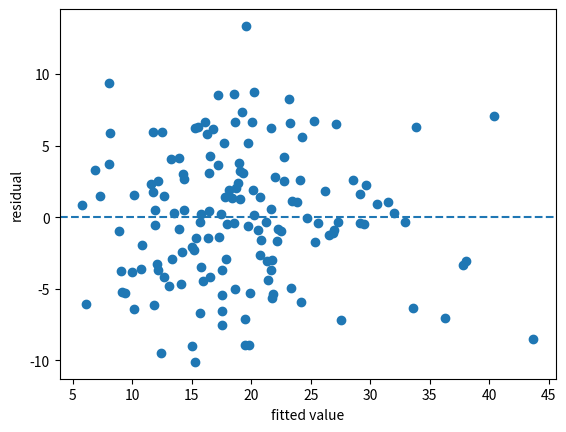

In [45]:
#등분산성 검정
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")

- 잔차가 y=0을 기준으로 random하게 산포되어 있으므로 등분산성을 만족한다.

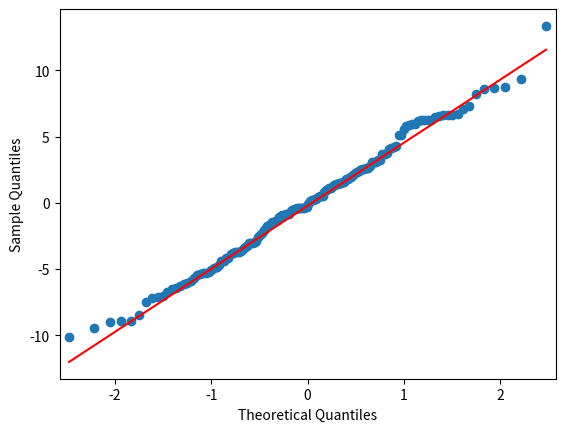

In [49]:
#정규성 검정
qqplot(reg_result.resid, line="q")
plt.show()

- 정규분포 직선을 중심으로 분포하므로 정규분포를 따른다

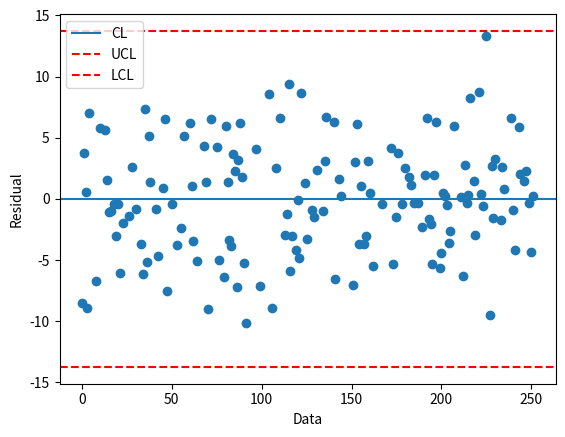

In [50]:
#잔차의 독립성 확인
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data"); plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-",label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label='UCL')
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label='LCL')
plt.legend();

- 잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고, 랜덤하게 산포되어 있으므로 독립성을 만족한다.

In [67]:
#평가용 데이터에 대한 성능 확인
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'],train_pred))
print("test data의 결정계수:", r2_score(df_test['FAT'],test_pred))

train data의 결정계수: 0.7050493672836544
test data의 결정계수: 0.7237849371397547


- train data에 대한 결정계수보다 test data의 결정계수가 더 높아 \
모형의 설명력이 뛰어난 편은 아니지만 다중공선성이 있는 변수들의 제거를 통해 일반화가 잘 이루어졌음을 확인할 수 있었다.

In [68]:
#설명변수 중요도
df_reg_coef=pd.DataFrame({"Coef":reg_result.params.values[1:]}, index = ['NECK','ABDOMEN','WRIST'])
df_reg_coef.plot.barh(y="Coef")

<AxesSubplot:>

- 직접 변수선택한 변수의 중요도는 ABDOMEN, NECK 변수의 회귀계수가 절대값 1에 가까워 중요한 변수임을 알 수 있다.
- ABDOMEN은 양의 상관관계, WRIST와 NECK는 음의 상관관계를 가진다.\
    -> 즉 복부둘레가 두꺼울수록 비만도가 높게 나타난다.\
    -> 목 둘레와 손목 두께가 두꺼울수록 비만도가 낮게 나타난다.

## 2) 후진제거법을 이용한 변수 선택
#RFE함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거

In [52]:
#목표변수/설명변수 분리
df_train_y = df_train["FAT"]
df_train_x = df_train.drop('FAT',axis=1)

#sklearn의 선형회귀 모델
model=LinearRegression()

#전체 변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator = model, n_features_to_select=5).fit(df_train_x, df_train_y)

#선택된 변수
selected_cols = df_train_x.columns[rfe.support_]
#제거된 변수
removed_cols = df_train_x.columns[~rfe.support_]

print("선택된 변수 : {}".format(selected_cols))
print("제거된 변수 : {}".format(removed_cols))

선택된 변수 : Index(['HEIGHT', 'NECK', 'ABDOMEN', 'WRIST', 'BMI'], dtype='object')
제거된 변수 : Index(['AGE', 'WEIGHT', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS',
       'FOREARM'],
      dtype='object')


In [53]:
#회귀 모델 생성
rfe_reg_model = smf.ols(formula = "FAT~HEIGHT+NECK+ABDOMEN+WRIST+BMI", data=df_train)

#적합
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     68.18
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.05e-36
Time:                        20:01:18   Log-Likelihood:                -441.56
No. Observations:                 150   AIC:                             895.1
Df Residuals:                     144   BIC:                             913.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.0206     11.198      1.609      0.1

In [54]:
#0.05가 넘는 t값을 가지는 변수중 가장 큰 값을 갖는 BMI 변수 삭제 
rfe_reg_model = smf.ols(formula = "FAT~HEIGHT+NECK+ABDOMEN+WRIST", data=df_train)

#적합
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     84.65
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           6.12e-37
Time:                        20:01:43   Log-Likelihood:                -442.28
No. Observations:                 150   AIC:                             894.6
Df Residuals:                     145   BIC:                             909.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.7469     11.160      1.501      0.1

In [55]:
#그 다음으로 큰 값을 갖는 WRIST 삭제 
rfe_reg_model = smf.ols(formula = "FAT~HEIGHT+NECK+ABDOMEN", data=df_train)

#적합
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.34e-37
Time:                        20:04:12   Log-Likelihood:                -443.24
No. Observations:                 150   AIC:                             894.5
Df Residuals:                     146   BIC:                             906.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4940     10.936      1.234      0.2

-> 남은 변수들의 p-value값이 0.05를 넘어가지 않으므로 변수 제거 중단

### 잔차의 가정 확인

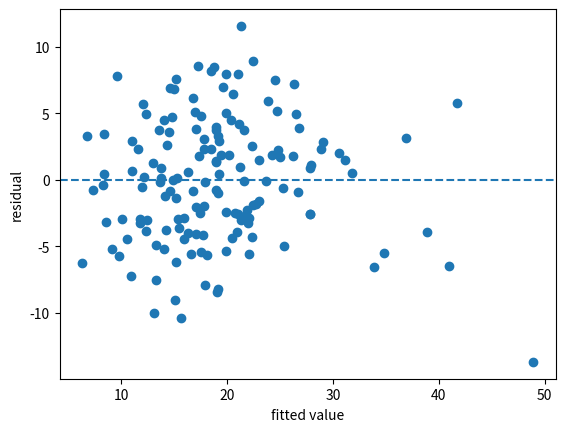

In [69]:
#등분산성 검정
plt.scatter(rfe_reg_result.fittedvalues, rfe_reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")

- 잔차가 y=0을 기준으로 random하게 산포되어 있으므로 등분산성을 만족한다.

In [71]:
#정규성 검정
qqplot(rfe_reg_result.resid, line="q")
plt.show()

- 정규분포 직선을 중심으로 분포하므로 정규분포를 따른다

In [72]:
#잔차의 독립성 확인
plt.scatter(df_train.index, rfe_reg_result.resid)
plt.xlabel("Data"); plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-",label='CL')
plt.axhline(y=3*np.std(rfe_reg_result.resid),linestyle="--",color="red",label='UCL')
plt.axhline(y=-3*np.std(rfe_reg_result.resid),linestyle="dashed",color="red",label='LCL')
plt.legend();

- 잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고, 랜덤하게 산포되어 있으므로 독립성을 만족한다.

In [63]:
#평가용 데이터에 대한 성능 확인
train_pred = rfe_reg_result.predict(df_train)
test_pred = rfe_reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'],train_pred))
print("test data의 결정계수:", r2_score(df_test['FAT'],test_pred))

train data의 결정계수: 0.6963106598248437
test data의 결정계수: 0.7299665856273805


- 후진제거법을 이용한 변수선택과 직접 비교해보며 변수를 선택했을 때 결과 차이가 뚜렷하지는 않지만,\
직접 확인하며 변수를 선택했을 때 train data에 대한 결정계수가 조금더 높고 test data에 대한 결정계수가 아주 약간 낮았다.\
직접 데이터를 확인해가며 조정했기 때문에 오히려 RFE 함수를 사용한 방법이 일반화가 되어 test data에 대한 결정계수가 약간 높았던 것 같다.
- test data에 대한 결정계수가 약 0.73으로 모형의 설명력이 아주 좋은 편은 아니기 때문에 정확한 예측이 필요한 상황이 아닌 노이즈가 조금 있는 환경이라면 사용할 수 있을 것 같다.

<AxesSubplot:>

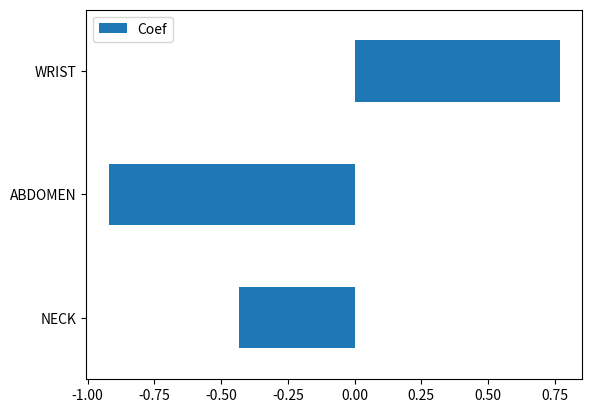

In [64]:
#설명변수 중요도
df_reg_coef=pd.DataFrame({"Coef":rfe_reg_result.params.values[1:]}, index = ['NECK','ABDOMEN','WRIST'])
df_reg_coef.plot.barh(y="Coef")

- 복부둘레와 목둘레가 음의 계수를 갖고 손목둘레가 양의 계수를 갖는다.
- 즉 손목둘레가 두꺼울수록 비만도가 더 높다.